# Extracting multimodal data features

`siibra` provides access to data features of different modalities using the `get_features` method, which accepts a feature modality and is sensitive to the selections configured in the atlas (parcellation, region). If not particular selection is made, `get_features` considers all brain regions of the current parcellation.

In [1]:
!pip install siibra siibra-jugex matplotlib nilearn

zsh:1: command not found: pip


In [2]:
import siibra
assert siibra.__version__ >= "0.3a25"

[siibra:INFO] Version: 0.3a25
[siibra:WARNING] This is a development release. Use at your own risk.
[siibra:INFO] Please file bugs and issues at https://github.com/FZJ-INM1-BDA/siibra-python.


### Prerequisite: Allow  `siibra` to connect to the EBRAINS Knowledge Graph

Most of the features linked to atlas regions are curated datasets in the [EBRAINS knowledge graph](https://kg.ebrainseu) (KG). To fetch data from the KG, you need to pass an EBRAINS KG authentication token to siibra. There are several ways to obtain a token, we will instruct `siibra` to use the device flow mechanism which is suitable for interactive use. As a prerequisite, you need to register for an EBRAINS account, as described [here](https://ebrains.eu/register).

In [3]:
import os
os.environ['SIIBRA_ENABLE_DEVICE_FLOW'] = 'true'
siibra.fetch_ebrains_token()

***
To continue, please go to https://iam.ebrains.eu/auth/realms/hbp/device?user_code=EQUS-BZIV
***


### Densities of neurotransmitter receptors

Transmitter receptor density fingerprints are linked to brain regions by their name in the EBRAINS Knowledge Graph. Like any data feature, they are accessed using the `get_features` method of the atlas, which makes use of the current selection in the atlas. The `get_features` method knows from the specified data modality that the match is determined from the brain region identified. Receptor densities come as a nicely structured datatype. Amongst other things, they can visualize themselves in a plot.

If we don't specify a particular selection, the atlas will return all available receptor density features linked to the parcellation map:

In [4]:
atlas = siibra.atlases['human']
julichbrain = atlas.get_parcellation("julich")
for f in siibra.get_features(julichbrain,"receptor"):
    print(f.matched_region.name, f)

[siibra:INFO] Multiple elements matched the specification 'julich' - the first in order was chosen: Julich-Brain Cytoarchitectonic Maps 2.9
[siibra:INFO] 12 receptor datasets skipped due to unsupported format.


Area IFS1 (IFS) ReceptorDistribution for Area ifs1 (IFS)
Area 4p (PreCG) ReceptorDistribution for Area 4p (PreCG)
Area 3b (PostCG) ReceptorDistribution for Area 3b (PostCG)
DG (Hippocampus) ReceptorDistribution for DG (Hippocampus)
Area 45 (IFG) ReceptorDistribution for Area 45 (IFG)
CA1 (Hippocampus) ReceptorDistribution for CA1 (Hippocampus)
Area hOc3v (LingG) ReceptorDistribution for Area hOc3v (LingG)
Area hOc1 (V1, 17, CalcS) ReceptorDistribution for Area hOc1 (V1, 17, CalcS)
Area 44 (IFG) ReceptorDistribution for Area 44 (IFG)
Area PGp (IPL) ReceptorDistribution for Area PGp (IPL)
Area PFm (IPL) ReceptorDistribution for Area PFm (IPL)
CA3 (Hippocampus) ReceptorDistribution for CA3 (Hippocampus)
CA1 (Hippocampus) ReceptorDistribution for CA1 (Hippocampus)
Area hOc3d (Cuneus) ReceptorDistribution for Area hOc3d (Cuneus)
Area 7A (SPL) ReceptorDistribution for Area 7A (SPL)
Area 44 (IFG) ReceptorDistribution for Area 44 (IFG)
Area PFop (IPL) ReceptorDistribution for Area PFop (IPL)
A

If we select a region, the returned list is filtered accordingly. 

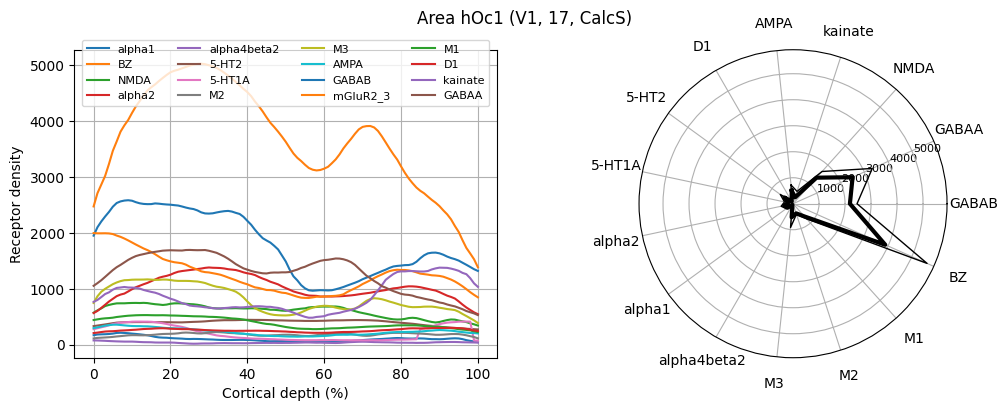

In [5]:
import siibra
atlas = siibra.atlases['human']
v1 = atlas.get_region('v1',parcellation="julich 2.9")
r, = siibra.get_features(v1,"receptor")
fig = r.plot(r.matched_region.name)

### Layer-specific cell distributions in cortical regions

This version of siibra provides a pre-release preview of layer-specific cell distributions in different areas of BigBrain.

[siibra:WARNING] PREVIEW DATA! CorticalCellDistribution data is only a pre-release snapshot. Contact support@ebrains.eu if you intend to use this data.


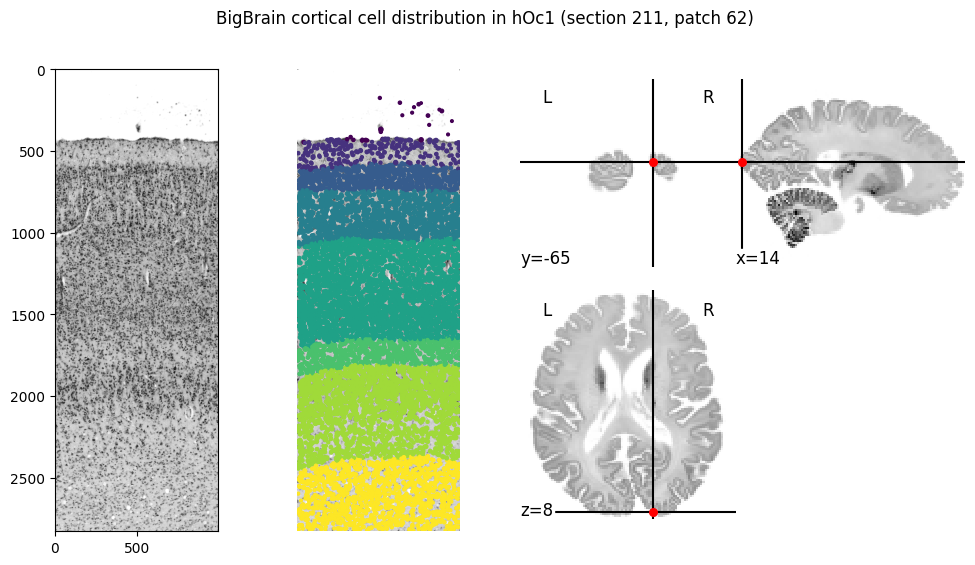

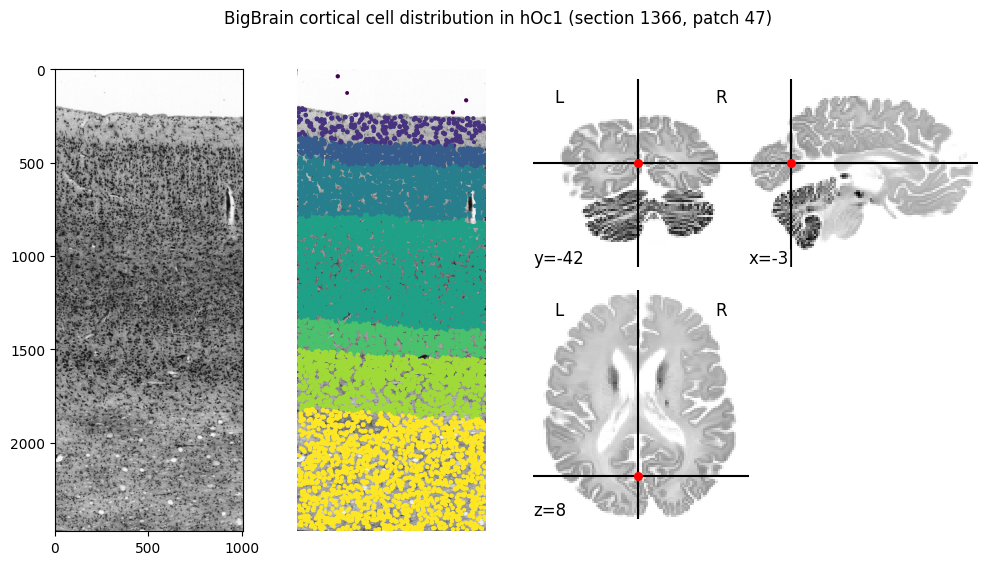

In [6]:
features = siibra.get_features(v1,"celldistribution")
for index in [0,-1]:
    # we plot only the first and last feature here
    fig = features[index].plot(features[index].matched_region.name)

### Gene Expressions from the Allen Atlas 

The atlas client can make calls to gene expression data from the Allen atlas and evaluate them in the ICBM space to find regional gene expression levels. It also has a list of available gene names for convenient selection. Gene expressions are linked to atlas regions by coordinates of their probes in MNI space. The `get_features` method detects this from the feature modality, and applies the mask of the regions that are currently selected in the atlas to filter the probes. We can visualize these filtered locations.

GeneExpression at Point in MNI152 2009c nonl asym [-7.0,-75.0,9.0]


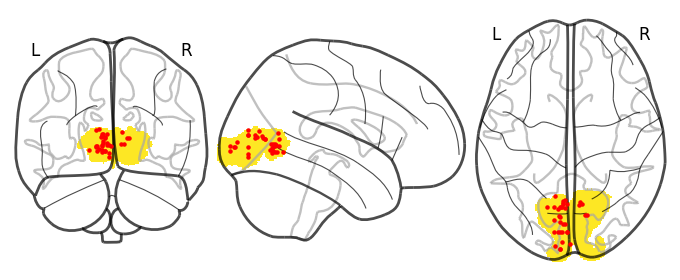

In [12]:
features = siibra.get_features(v1,"gene",gene="GABARAPL2")
print(features[0])

# plot
from nilearn import plotting
all_coords = [tuple(g.location) for g in features]
mask = v1.build_mask("mni152")
display = plotting.plot_glass_brain(mask, cmap='viridis')
display.add_markers(all_coords,marker_size=5) 

### Connectivity matrices
For `siibra`, a connectivity matrix is a data feature like the others below, and can be found using the same `get_features` function just by choosing another modality. `siibra` knows from the modality type that this type of data does not match to the selected brain region in the atlas, but to the selected parcellation. Therefore, `get_features` return connectivity datasets that are defined for the selected parcellation. 

To learn about the nature of the provided connectivity, the `src_info` attribute provides a detailed description of the dataset. 

[siibra:INFO] Found 2 versions for dataset 'Parcellation-based structural and resting-state functional brain connectomes of a healthy cohort' (v1.0, v1.1). Will use v1.1 per default.


AttributeError: <class 'siibra.features.connectivity.StreamlineCounts'> has no attribute array

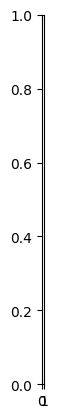

In [14]:
# Get the first four connectivity matrices available for the parcellation
features = siibra.get_features(julichbrain, "StreamlineCounts")[:4]

# format dataset names for use as figure titles
from textwrap import wrap
titleformat = lambda text : "\n".join(wrap(text.replace('_',' '),20)) 

# plot the matrices
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
for i,feature in enumerate(features):
    ax = fig.add_subplot(1,len(features),i+1)
    ax.imshow(np.log(feature.matrix),cmap=plt.cm.hot)
    ax.set_title(titleformat(feature.name),size=10)
fig.show()

### Locations of iEEG recordings

iEEG data is queried per session/subject. The data is organized into multiple electrodes per session, and multiple contact points per electrode. Iterating over a session yields its electrodes. Iterating over each electrode yields its contact points. Each of these items are themselves of type `SpatialFeature`, so they have a `.location` and can be matched against an atlas. Below, we use this to visualize MNI coordinates of contact points which correspond to electrodes touching the selected region. We highlight the contact points inside the selected atlas region in red.

In [ ]:
sessions = siibra.get_features(v1,"ieeg")

coords = [pt
          for session in sessions
          for electrode in session
          for pt in electrode.location
          if electrode.match(v1)]

from nilearn import plotting
mask = v1.build_mask("mni152")
plotting.view_markers(
    [tuple(pt) for pt in coords],
    ["red" if pt.intersects(mask) else "blue"
    for pt in coords ],
    marker_size=3)